The main() function orchestrates the execution of these functions to perform the spatial analysis. 
It specifies the raster file
* converts the raster to a DataFrame
* displays the raster

* specifies the aperture size for the H3 hexagons
* reads the list of H3 indices
* gets the H3 indices for the DataFrame

* saves the DataFrame to a CSV file
* gets the fill color for the DataFrame

* defines a layer to display on a map
* sets the viewport location and renders the map

* specifies the original raster file
* opens the original raster file
* reads the first band of the raster file
* replaces infinite values with zero

* opens the original raster file
* retrieves the metadata from the original raster file
* updates the metadata for the new raster file
* saves the raster array as a new raster file and fuzzifies the DataFrame

The script is designed to be run as a **standalone program.**

In [1]:
import os
import h3
import rasterio 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pydeck as pdk
from rasterio.plot import show
from shapely.geometry import Polygon

os.environ['USE_PYGEOS'] = '0'  # Disable PyGEOS to avoid any conflicts with Geopandas

In [2]:
# Function to convert raster to DataFrame
def raster_to_df(raster_file):
    with rasterio.open(raster_file) as src:  # Open the raster file
        band1 = src.read(1)  # Read the first band of the raster
        cols, rows = np.meshgrid(np.arange(band1.shape[1]), np.arange(band1.shape[0]))  # Create a meshgrid of column and row indices
        lons, lats = rasterio.transform.xy(src.transform, rows, cols)  # Convert the column and row indices to longitude and latitude
    
    lats = np.array(lats).flatten()  # Flatten the latitude array
    lons = np.array(lons).flatten()  # Flatten the longitude array
    
    df = pd.DataFrame({  # Create a DataFrame from the latitude, longitude, and band1 arrays
       'lat': lats,
       'lon': lons,
       'value': band1.flatten()})
    
    df = df[df['value'] != 0]  # Remove rows where 'value' is 0
    df = df[~np.isinf(df['value'])]  # Remove rows where 'value' is infinite
    
    return band1, df

In [3]:
def get_h3_indices(df, aperture_size, h3_list):
    hex_col = 'hex'+str(aperture_size)
    df[hex_col] = df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lon'], aperture_size), axis=1)
    df = df[df[hex_col].isin(h3_list[hex_col])]
    hex_df = df.groupby(hex_col)['value'].mean().reset_index()
    return hex_df


In [4]:
# Function to get fill color for the DataFrame
def get_fill_color(df, value_column, colormap_name):
    min_value = df[value_column].min()  # Get the minimum 'value'
    max_value = df[value_column].max()  # Get the maximum 'value'
    cmap = plt.get_cmap(colormap_name)  # Get the colormap
    norm = mcolors.Normalize(vmin=min_value, vmax=max_value)  # Normalize the 'value' column
    df['color'] = df[value_column].apply(lambda value: [int(rgba * 255) for rgba in cmap(1 - norm(value))[:3]])  # Create a new 'color' column based on the normalized 'value'
    return df

In [5]:
# Function to fuzzify the DataFrame
def fuzzify(df):
    df_array = df['Value'].values  # Get the 'Value' column as a numpy array
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))  # Fuzzify the array
    return fuzzified_array

In [10]:
def main():
    raster_file = '../raster/industry/industry.tif'  # Specify the raster file
    band1, df = raster_to_df(raster_file)  # Convert the raster to a DataFrame
    show(band1)  # Show the raster

    APERTURE_SIZE = 9  # Specify the aperture size for the H3 hexagons
    h3_list = gpd.read_file("../app_data/h3_pzh_polygons.shp")  # Read the list of H3 indices
    hex_df = get_h3_indices(df, APERTURE_SIZE, h3_list)  # Get the H3 indices for the DataFrame
    hex_df.to_csv('../hex/industry_thijs.csv')  # Save the DataFrame to a CSV file

    #fuzzy_farm = fuzzify(farm_hex)  # Fuzzify the DataFrame

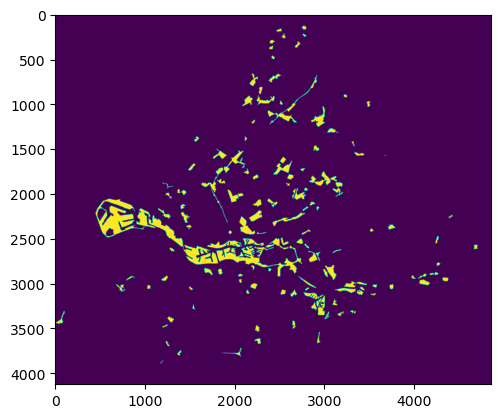

In [11]:
if __name__ == "__main__":
    main()